# 제4 고지 : 신경망 만들기 
## STEP 51 : MNIST 학습

<p align='center'>
  <img src='../assets/그림 51-1.png' align='center' width='50%'>
</p>

이전에 구현한 `Dataset` 에서 미니배치 단위로 데이터를 꺼내는 `DataLoader`의 관계는 위의 그림과 같다.
이번 단계에서는 위의 데이터셋 구조를 활용하여 새로운 데이터셋을 학습해본다.  
우선  MNIST 데이터셋이 무엇인지 부터 간략하게 살펴보자.

### 51.1 MNIST 데이터셋

`dezero/dataset.py` 에 MNIST 클래스를 이용해서 구체적으로 살펴보자. 


60000
10000
<class 'numpy.ndarray'> (1, 28, 28)
5


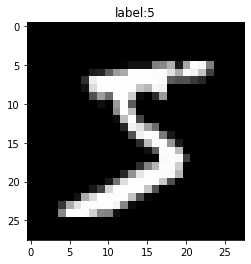

In [1]:
import sys
sys.path.append("..")

import dezero
import matplotlib.pyplot as plt

train_set = dezero.datasets.MNIST(train=True,transform=None)
test_set = dezero.datasets.MNIST(train=False,transform=None)

print(len(train_set))
print(len(test_set))

x,t = train_set[0]
print(type(x),x.shape)
print(t)


# 데이터 예시 
plt.imshow(x.reshape(28,28),cmap="gray")
plt.title(f"label:{t}")
plt.show()


해당 이미지를 신경망에 넣기 전 입력데이터를  다음 세 가지를 전처리한다.

1. (1,28,28) 형상 입력 데이터를 `flatten`하여 **(784,)** 형상으로 변환
2. 데이터 타입을 **np.float32 로 변환**한다.
3. `x /= 255.0` 를 통해 **0.0 ~ 1.0** 사이가 되도록 한다.

<span style='background-color : #ffdce0'>💡<b>해당 전처리는 `MNIST` 클래스에 기본적으로 설정되어 있다. </b></span>


### 51.2 MNIST 학습하기 

In [2]:
import sys
sys.path.append("..")

import dezero
from dezero import optimizers,DataLoader
import dezero.functions as F
from dezero.models import MLP


log_interval = 1 # 20 epoch 마다 logging

# 하이퍼 파라미터 설정
######################################
max_epoch = 5
batch_size = 100
hidden_size = 1000
######################################

# 데이터 읽기 / 모델, 옵티마이저 생성
######################################
train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)
train_loader = DataLoader(train_set,batch_size)
test_loader = DataLoader(test_set,batch_size,shuffle=False) # 테스트 데이터는 평가용이므로 shuffle=False
######################################


model = MLP((hidden_size, 10))
optimizer = optimizers.SGD().setup(model)



for epoch in range(max_epoch):
    sum_loss,sum_acc = 0,0

    for x,t in train_loader : # 미니배치 
        # 기울기 산출 / 매개변수 갱신
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y,t) # 정확도 계산
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc +=float(acc.data) * len(t) 

    # 에폭마다 학습 경과 출력
    avg_loss = sum_loss / len(train_set)
    avg_acc = sum_acc / len(train_set)
    if epoch % log_interval == 0:
        print('epoch %d, loss %.2f, acc %.2f' % (epoch + 1, avg_loss,avg_acc))
        
    sum_loss, sum_acc = 0,0
    with dezero.no_grad():
        for x,t in test_loader:
            # 기울기 산출 / 매개변수 갱신
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y,t) # 정확도 계산

            sum_loss += float(loss.data) * len(t)
            sum_acc +=float(acc.data) * len(t) 
            
    avg_loss = sum_loss / len(test_set)
    avg_acc = sum_acc / len(test_set)
    if epoch % log_interval == 0:
        print('test loss %.2f, acc %.2f' % (avg_loss,avg_acc))

epoch 1, loss 1.93, acc 0.54
test loss 1.56, acc 0.74
epoch 2, loss 1.30, acc 0.77
test loss 1.06, acc 0.81
epoch 3, loss 0.93, acc 0.82
test loss 0.80, acc 0.84
epoch 4, loss 0.75, acc 0.84
test loss 0.66, acc 0.86
epoch 5, loss 0.64, acc 0.85
test loss 0.58, acc 0.86


### 51.3 모델 개선하기 

방금 학습한 모델 `MLP`의 활성화 함수는 **sigmoid** 함수였다. 그런데 최근에는 **ReLU(Rectified Linear Unit)** 라는 함수가 더 자주 사용되는데, 해당 함수는 다음 특징을 가진다.
$$
f(x) = \begin{cases}
x, & \text{if } x > 0 \\
0, & \text{otherwise}
\end{cases}
$$

- 입력이 0보다 크면 그대로 출력
- 입력이 0 이하면 0을 출력

<span style='background-color : #ffdce0'>💡<b>즉, ReLU는 신호를 `통과` 또는 `봉쇄` 한다.</b></span>

그래서 해당 함수를 구현해보자.

```python
class ReLU(Function):
    def forward(self, x):
        y = np.maximum(x, 0.0) # 1. x 와 0.0 중 큰 값을 반환.
        return y

    def backward(self, gy):
        x, = self.inputs
        mask = x.data > 0 # 2. 0 보다 큰 값은 그대로 기울기를 흘려보내주고, 이하면 기울기를 0으로 설정하는 mask
        gx = gy * mask # 3. 기울기 곱
        return gx

def relu(x):
    return ReLU()(x)

```


In [4]:
import sys
sys.path.append("..")

import dezero
from dezero import optimizers,DataLoader
import dezero.functions as F
from dezero.models import MLP


log_interval = 1 # 20 epoch 마다 logging

# 하이퍼 파라미터 설정
max_epoch = 5
batch_size = 100
hidden_size = 1000

# 데이터 읽기 / 모델, 옵티마이저 생성
train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)
train_loader = DataLoader(train_set,batch_size)
test_loader = DataLoader(test_set,batch_size,shuffle=False) # 테스트 데이터는 평가용이므로 shuffle=False

######################################
# activation, optimizer  변경
model = MLP((hidden_size, 10),activation=F.relu)
optimizer = optimizers.Adam().setup(model)
######################################




for epoch in range(max_epoch):
    sum_loss,sum_acc = 0,0

    for x,t in train_loader : # 미니배치 
        # 기울기 산출 / 매개변수 갱신
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y,t) # 정확도 계산
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc +=float(acc.data) * len(t) 

    # 에폭마다 학습 경과 출력
    avg_loss = sum_loss / len(train_set)
    avg_acc = sum_acc / len(train_set)
    if epoch % log_interval == 0:
        print('epoch %d, loss %.2f, acc %.2f' % (epoch + 1, avg_loss,avg_acc))
        
    sum_loss, sum_acc = 0,0
    with dezero.no_grad():
        for x,t in test_loader:
            # 기울기 산출 / 매개변수 갱신
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y,t) # 정확도 계산

            sum_loss += float(loss.data) * len(t)
            sum_acc +=float(acc.data) * len(t) 
            
    avg_loss = sum_loss / len(test_set)
    avg_acc = sum_acc / len(test_set)
    if epoch % log_interval == 0:
        print('test loss %.2f, acc %.2f' % (avg_loss,avg_acc))

epoch 1, loss 0.23, acc 0.93
test loss 0.11, acc 0.97
epoch 2, loss 0.09, acc 0.97
test loss 0.08, acc 0.98
epoch 3, loss 0.05, acc 0.98
test loss 0.07, acc 0.98
epoch 4, loss 0.04, acc 0.99
test loss 0.07, acc 0.98
epoch 5, loss 0.03, acc 0.99
test loss 0.06, acc 0.98
